In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from datetime import date, datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_and_prepare_data(file_path, test_year=2023):
    """Load data and create train/test split by year"""
    print("Loading and preparing data...")
    df = pd.read_parquet(file_path)
    
    print(f"Loaded data with shape: {df.shape}")
    print(f"Sample columns: {list(df.columns)[:20]}...")
    
    # Handle timestamp creation
    if 'timestamp' in df.columns:
        print("Found existing timestamp column")
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    else:
        print("Creating timestamp from one-hot encoded columns...")
        
        ride_name_cols = [col for col in df.columns if col.startswith('ride_name_')]
        if ride_name_cols:
            df['ride_name'] = df[ride_name_cols].idxmax(axis=1).str.replace('ride_name_', '')
        else:
            df['ride_name'] = 'unknown'

        year_cols = [col for col in df.columns if col.startswith('year_') and col.replace('year_', '').isdigit()]
        if year_cols:
            df['year'] = df[year_cols].idxmax(axis=1).str.replace('year_', '').astype(int)
        else:
            df['year'] = 2022

        month_cols = [col for col in df.columns if col.startswith('month_') and col.replace('month_', '').isdigit()]
        if month_cols:
            df['month'] = df[month_cols].idxmax(axis=1).str.replace('month_', '').astype(int)
        else:
            if 'month_sin' in df.columns and 'month_cos' in df.columns:
                month_angle = np.arctan2(df['month_sin'], df['month_cos'])
                df['month'] = ((month_angle / (2 * np.pi) * 12) + 12) % 12 + 1
                df['month'] = df['month'].round().astype(int).clip(1, 12)
            else:
                df['month'] = 6
        
        if 'weekday' in df.columns:
            df['day_of_week'] = df['weekday']
        elif 'day_of_week' in df.columns:
            pass
        elif 'weekday_sin' in df.columns and 'weekday_cos' in df.columns:
            weekday_angle = np.arctan2(df['weekday_sin'], df['weekday_cos'])
            df['day_of_week'] = ((weekday_angle / (2 * np.pi) * 7) + 7) % 7
            df['day_of_week'] = df['day_of_week'].round().astype(int) % 7
        else:
            df['day_of_week'] = 1
        
        if 'hour_sin' in df.columns and 'hour_cos' in df.columns:
            hour_angle = np.arctan2(df['hour_sin'], df['hour_cos'])
            df['hour'] = ((hour_angle / (2 * np.pi) * 24) + 24) % 24
            df['hour'] = df['hour'].round().astype(int) % 24
        else:
            df['hour'] = 12
        
        df['day'] = 15
        try:
            df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
        except Exception as e:
            print(f"Error creating timestamp: {e}")
            df['month'] = df['month'].clip(1, 12)
            df['day'] = df['day'].clip(1, 28)
            df['hour'] = df['hour'].clip(0, 23)
            df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
    
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day_of_month'] = df['timestamp'].dt.day
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['date'] = df['timestamp'].dt.date
    
    print(f"Data years available: {sorted(df['year'].unique())}")
    print(f"Data date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    
    covid_mask = (df['year'] >= 2020) & (df['year'] <= 2021)
    covid_data_count = covid_mask.sum()
    if covid_data_count > 0:
        print(f"⚠️  Filtering out {covid_data_count} COVID-period records (2020-2021)")
        df = df[~covid_mask]
    
    reasonable_hours = (df['hour'] >= 9) & (df['hour'] <= 21)
    before_filter = len(df)
    df = df[reasonable_hours]
    print(f"Filtered to operating hours (9-21): {len(df)} records (removed {before_filter - len(df)})")
    
    train_mask = df['year'] < test_year
    test_mask = df['year'] == test_year
    
    train_data = df[train_mask].copy()
    test_data = df[test_mask].copy()
    
    print(f"Train data: {len(train_data)} samples ({train_data['year'].min()}-{train_data['year'].max()})")
    print(f"Test data: {len(test_data)} samples ({test_data['year'].unique()})")
    
    return train_data, test_data

In [3]:
def create_features(df):
    """Create engineered features for the model"""
    print(f"Creating features for {len(df)} records...")
    
    df = df.copy()
    
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_friday'] = (df['day_of_week'] == 4).astype(int)
    df['is_sunday'] = (df['day_of_week'] == 6).astype(int)
    
    conditions = [
        (df['month'] >= 3) & (df['month'] <= 5),
        (df['month'] >= 6) & (df['month'] <= 8),
        (df['month'] >= 9) & (df['month'] <= 11),
        (df['month'] == 12) | (df['month'] <= 2)
    ]
    seasons = ['spring', 'summer', 'fall', 'winter']
    df['season'] = np.select(conditions, seasons, default='spring')
    
    df['time_of_day'] = 'morning'
    df.loc[df['hour'].between(12, 16), 'time_of_day'] = 'afternoon'
    df.loc[df['hour'].between(17, 19), 'time_of_day'] = 'evening'
    df.loc[df['hour'] >= 20, 'time_of_day'] = 'night'
    
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df['is_peak_hour'] = df['hour'].isin([11, 12, 13, 14, 15, 16]).astype(int)
    df['is_opening_hour'] = df['hour'].isin([9, 10]).astype(int)
    df['is_closing_hour'] = df['hour'].isin([19, 20, 21]).astype(int)
    
    df['is_summer_vacation'] = df['month'].isin([6, 7, 8]).astype(int)
    
    print("Created temporal and categorical features")
    return df

In [4]:
def prepare_model_features(df):
    """Prepare features for model training"""
    print("Preparing features for model...")
    
    exclude_cols = [
        'wait_time', 'timestamp', 'date', 'year', 'month', 'day_of_month', 
        'hour', 'day_of_week', 'ride_name'
    ]
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    categorical_features = ['season', 'time_of_day']
    
    numerical_features = []
    for col in feature_cols:
        if col not in categorical_features:
            if df[col].dtype in ['int64', 'float64']:
                skip_prefixes = ['ride_name_', 'season_', 'time_of_day_']
                if not any(col.startswith(prefix) for prefix in skip_prefixes):
                    numerical_features.append(col)
    
    important_onehot = [col for col in df.columns if col.startswith('ride_name_')]
    if important_onehot:
        categorical_features.extend(important_onehot)
    
    print(f"Categorical features: {categorical_features}")
    print(f"Numerical features: {numerical_features}")
    
    all_features = categorical_features + numerical_features
    
    available_features = [col for col in all_features if col in df.columns]
    
    X = df[available_features].copy()
    y = df['wait_time'].copy()
    
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].fillna('unknown')
        else:
            X[col] = X[col].fillna(X[col].median())
    
    mask = ~y.isna()
    X = X[mask]
    y = y[mask]
    
    print(f"Final feature matrix shape: {X.shape}")
    print(f"Features used: {list(X.columns)}")
    
    return X, y, categorical_features, numerical_features

In [5]:
def create_preprocessing_pipeline(categorical_features, numerical_features):
    """Create preprocessing pipeline"""

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ],
        remainder='passthrough'
    )
    
    return preprocessor


In [6]:
def train_model(X_train, y_train, categorical_features, numerical_features, model_type='ridge'):
    """Train the wait time prediction model"""
    print(f"Training {model_type} model...")
    
    preprocessor = create_preprocessing_pipeline(categorical_features, numerical_features)
    
    if model_type == 'ridge':
        model = Ridge(alpha=1.0, random_state=42)
    elif model_type == 'gradient_boosting':
        model = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=42
        )
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    print(f"Model trained successfully with {len(X_train)} samples")
    
    return pipeline

In [7]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Evaluate model performance"""
    print(f"Evaluating {model_name}...")
    
    y_pred = model.predict(X_test)
    y_pred = np.maximum(y_pred, 0)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    epsilon = 1e-8
    abs_pct_errors = np.abs(y_test - y_pred) / (np.abs(y_test) + epsilon)
    non_zero_mask = y_test > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100 if non_zero_mask.sum() > 0 else 0
    
    print(f"{model_name} Performance:")
    print(f"  MAE: {mae:.2f} minutes")
    print(f"  RMSE: {rmse:.2f} minutes")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

    wait_ranges = [(0, 10), (10, 30), (30, 60), (60, float('inf'))]
    print(f"\n{model_name} Performance by Wait Time Range:")
    for min_wait, max_wait in wait_ranges:
        mask = (y_test >= min_wait) & (y_test < max_wait)
        if np.sum(mask) > 0:
            range_mae = mean_absolute_error(y_test[mask], y_pred[mask])
            range_label = f"{min_wait}-{max_wait if max_wait != float('inf') else '∞'} min"
            print(f"  {range_label}: MAE {range_mae:.2f} (n={np.sum(mask)})")
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'y_pred': y_pred
    }

In [8]:
def evaluate_model_by_ride(model, test_data, model_name="Model"):
    """Evaluate model performance broken down by individual rides"""
    print(f"\nEvaluating {model_name} performance by ride...")
    
    # Prepare test features
    X_test, y_test, _, _ = prepare_model_features(test_data)
    y_pred = model.predict(X_test)
    y_pred = np.maximum(y_pred, 0)
    
    # Create results dataframe with ride information
    test_data_clean = test_data.copy()
    test_data_clean = test_data_clean[~test_data_clean['wait_time'].isna()]
    
    # Get ride names
    ride_name_cols = [col for col in test_data_clean.columns if col.startswith('ride_name_')]
    if ride_name_cols:
        test_data_clean['ride_name'] = test_data_clean[ride_name_cols].idxmax(axis=1).str.replace('ride_name_', '')
    else:
        test_data_clean['ride_name'] = 'unknown'
    
    # Create results dataframe
    results_df = pd.DataFrame({
        'ride_name': test_data_clean['ride_name'].values,
        'actual': y_test.values,
        'predicted': y_pred,
        'absolute_error': np.abs(y_pred - y_test.values)
    })
    
    # Calculate metrics by ride
    ride_metrics = []
    rides = results_df['ride_name'].unique()
    
    for ride in rides:
        ride_data = results_df[results_df['ride_name'] == ride]
        
        if len(ride_data) < 5:  # Skip rides with too few samples
            continue
            
        mae = mean_absolute_error(ride_data['actual'], ride_data['predicted'])
        rmse = np.sqrt(mean_squared_error(ride_data['actual'], ride_data['predicted']))
        r2 = r2_score(ride_data['actual'], ride_data['predicted'])
        
        # Calculate MAPE
        epsilon = 1e-8
        abs_pct_errors = np.abs(ride_data['actual'] - ride_data['predicted']) / (np.abs(ride_data['actual']) + epsilon)
        non_zero_mask = ride_data['actual'] > 0
        mape = np.mean(abs_pct_errors[non_zero_mask]) * 100 if non_zero_mask.sum() > 0 else 0
        
        ride_metrics.append({
            'ride_name': ride,
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'sample_count': len(ride_data),
            'avg_wait_time': ride_data['actual'].mean()
        })
    
    ride_metrics_df = pd.DataFrame(ride_metrics).sort_values('mae')
    
    # Print summary
    print(f"\nPerformance by Ride (sorted by MAE):")
    print("=" * 80)
    for _, row in ride_metrics_df.iterrows():
        print(f"{row['ride_name']:<25} | MAE: {row['mae']:>6.2f} | RMSE: {row['rmse']:>6.2f} | "
              f"R²: {row['r2']:>6.3f} | Samples: {row['sample_count']:>4d} | Avg Wait: {row['avg_wait_time']:>5.1f}min")
    
    return ride_metrics_df, results_df


In [9]:
def plot_per_ride_performance(ride_metrics_df, results_df, model_name="Model"):
    """Create improved, readable visualizations for per-ride model performance"""
    
    # Helper function to truncate long ride names
    def truncate_name(name, max_length=15):
        return name[:max_length] + "..." if len(name) > max_length else name
    
    # Figure 1: Main Performance Metrics (2x2 grid)
    fig1 = plt.figure(figsize=(16, 12))
    
    # 1. MAE by Ride (Bar Chart)
    plt.subplot(2, 2, 1)
    ride_metrics_sorted = ride_metrics_df.sort_values('mae')
    truncated_names = [truncate_name(name) for name in ride_metrics_sorted['ride_name']]
    
    bars = plt.bar(range(len(ride_metrics_sorted)), ride_metrics_sorted['mae'], 
                   alpha=0.7, color='steelblue')
    plt.xticks(range(len(ride_metrics_sorted)), truncated_names, rotation=45, ha='right', fontsize=11)
    plt.ylabel('Mean Absolute Error (minutes)', fontsize=12)
    plt.title(f'{model_name}: MAE by Ride', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Add sample count annotations (only for bars > certain height to avoid clutter)
    for i, (bar, row) in enumerate(zip(bars, ride_metrics_sorted.itertuples())):
        if bar.get_height() > ride_metrics_sorted['mae'].max() * 0.3:  # Only show for higher bars
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f"n={row.sample_count}", ha='center', va='bottom', fontsize=9)
    
    # 2. R² by Ride (Bar Chart)
    plt.subplot(2, 2, 2)
    ride_metrics_r2 = ride_metrics_df.sort_values('r2', ascending=False)
    truncated_names_r2 = [truncate_name(name) for name in ride_metrics_r2['ride_name']]
    
    colors = ['darkgreen' if x >= 0.5 else 'orange' if x >= 0.3 else 'darkred' for x in ride_metrics_r2['r2']]
    plt.bar(range(len(ride_metrics_r2)), ride_metrics_r2['r2'], color=colors, alpha=0.8)
    plt.xticks(range(len(ride_metrics_r2)), truncated_names_r2, rotation=45, ha='right', fontsize=11)
    plt.ylabel('R² Score', fontsize=12)
    plt.title(f'{model_name}: R² by Ride', fontsize=14, fontweight='bold')
    plt.axhline(y=0.5, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Good (0.5+)')
    plt.axhline(y=0.3, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Fair (0.3+)')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Sample Count vs MAE (Scatter)
    plt.subplot(2, 2, 3)
    scatter = plt.scatter(ride_metrics_df['sample_count'], ride_metrics_df['mae'], 
                         alpha=0.7, s=80, c=ride_metrics_df['r2'], cmap='RdYlGn', 
                         edgecolors='black', linewidth=0.5)
    plt.colorbar(scatter, label='R² Score')
    
    # Only annotate outliers to avoid clutter
    high_error = ride_metrics_df['mae'] > ride_metrics_df['mae'].quantile(0.8)
    low_samples = ride_metrics_df['sample_count'] < ride_metrics_df['sample_count'].quantile(0.2)
    
    for _, row in ride_metrics_df[high_error | low_samples].iterrows():
        plt.annotate(truncate_name(row['ride_name'], 12), 
                    (row['sample_count'], row['mae']), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=9, alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    plt.xlabel('Number of Test Samples', fontsize=12)
    plt.ylabel('Mean Absolute Error (minutes)', fontsize=12)
    plt.title('Sample Count vs Model Performance\n(Color = R² Score)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # 4. Average Wait Time vs MAE (Scatter)
    plt.subplot(2, 2, 4)
    scatter2 = plt.scatter(ride_metrics_df['avg_wait_time'], ride_metrics_df['mae'], 
                          alpha=0.7, s=ride_metrics_df['sample_count']/50, 
                          c=ride_metrics_df['r2'], cmap='RdYlGn',
                          edgecolors='black', linewidth=0.5)
    plt.colorbar(scatter2, label='R² Score')
    
    # Annotate extreme cases
    extreme_cases = (ride_metrics_df['mae'] > ride_metrics_df['mae'].quantile(0.9)) | \
                   (ride_metrics_df['avg_wait_time'] > ride_metrics_df['avg_wait_time'].quantile(0.9))
    
    for _, row in ride_metrics_df[extreme_cases].iterrows():
        plt.annotate(truncate_name(row['ride_name'], 12), 
                    (row['avg_wait_time'], row['mae']), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=9, alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    plt.xlabel('Average Wait Time (minutes)', fontsize=12)
    plt.ylabel('Mean Absolute Error (minutes)', fontsize=12)
    plt.title('Average Wait Time vs Model Error\n(Size = Sample Count, Color = R²)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Performance Comparison (Best vs Worst)
    fig2 = plt.figure(figsize=(16, 6))
    
    # Best and worst performing rides
    n_rides_to_show = min(5, len(ride_metrics_df))
    best_rides = ride_metrics_df.nsmallest(n_rides_to_show, 'mae')
    worst_rides = ride_metrics_df.nlargest(n_rides_to_show, 'mae')
    
    # 1. Best Performing Rides
    plt.subplot(1, 2, 1)
    best_ride_data = []
    colors_best = plt.cm.Greens(np.linspace(0.4, 0.9, len(best_rides)))
    
    for i, (_, row) in enumerate(best_rides.iterrows()):
        ride_data = results_df[results_df['ride_name'] == row['ride_name']]
        if len(ride_data) > 10:  # Only plot if enough data
            sample_data = ride_data.sample(min(100, len(ride_data)))  # Limit points for clarity
            plt.scatter(sample_data['actual'], sample_data['predicted'], 
                       alpha=0.6, s=30, color=colors_best[i], 
                       label=f"{truncate_name(row['ride_name'], 12)} (MAE: {row['mae']:.1f})")
    
    max_val = min(60, max(results_df['actual'].max(), results_df['predicted'].max()))  # Cap for readability
    plt.plot([0, max_val], [0, max_val], 'k--', linewidth=2, alpha=0.7, label='Perfect Prediction')
    plt.xlabel('Actual Wait Time (minutes)', fontsize=12)
    plt.ylabel('Predicted Wait Time (minutes)', fontsize=12)
    plt.title('Best Performing Rides: Actual vs Predicted', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    
    # 2. Worst Performing Rides
    plt.subplot(1, 2, 2)
    colors_worst = plt.cm.Reds(np.linspace(0.4, 0.9, len(worst_rides)))
    
    for i, (_, row) in enumerate(worst_rides.iterrows()):
        ride_data = results_df[results_df['ride_name'] == row['ride_name']]
        if len(ride_data) > 10:  # Only plot if enough data
            sample_data = ride_data.sample(min(100, len(ride_data)))  # Limit points for clarity
            plt.scatter(sample_data['actual'], sample_data['predicted'], 
                       alpha=0.6, s=30, color=colors_worst[i], 
                       label=f"{truncate_name(row['ride_name'], 12)} (MAE: {row['mae']:.1f})")
    
    plt.plot([0, max_val], [0, max_val], 'k--', linewidth=2, alpha=0.7, label='Perfect Prediction')
    plt.xlabel('Actual Wait Time (minutes)', fontsize=12)
    plt.ylabel('Predicted Wait Time (minutes)', fontsize=12)
    plt.title('Worst Performing Rides: Actual vs Predicted', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max_val)
    plt.ylim(0, max_val)
    
    plt.tight_layout()
    plt.show()
    
    # Figure 3: Performance Summary Table (as a figure)
    fig3 = plt.figure(figsize=(14, 8))
    
    # Create a summary table visualization
    plt.subplot(1, 1, 1)
    plt.axis('off')
    
    # Prepare data for table
    display_df = ride_metrics_df.copy()
    display_df['ride_name'] = display_df['ride_name'].apply(lambda x: truncate_name(x, 20))
    display_df = display_df.round({'mae': 1, 'rmse': 1, 'r2': 3, 'mape': 1, 'avg_wait_time': 1})
    
    # Create table
    table_data = []
    headers = ['Ride Name', 'MAE', 'RMSE', 'R²', 'MAPE%', 'Samples', 'Avg Wait']
    
    for _, row in display_df.sort_values('mae').iterrows():
        table_data.append([
            row['ride_name'],
            f"{row['mae']:.1f}",
            f"{row['rmse']:.1f}",
            f"{row['r2']:.3f}",
            f"{row['mape']:.1f}",
            f"{row['sample_count']:,}",
            f"{row['avg_wait_time']:.1f}"
        ])
    
    # Color coding for performance
    cell_colors = []
    for _, row in display_df.sort_values('mae').iterrows():
        row_colors = ['lightgray']  # Ride name column
        
        # MAE coloring
        if row['mae'] < 3:
            row_colors.append('lightgreen')
        elif row['mae'] < 6:
            row_colors.append('lightyellow')
        else:
            row_colors.append('lightcoral')
        
        # RMSE coloring
        if row['rmse'] < 4:
            row_colors.append('lightgreen')
        elif row['rmse'] < 8:
            row_colors.append('lightyellow')
        else:
            row_colors.append('lightcoral')
        
        # R² coloring
        if row['r2'] > 0.5:
            row_colors.append('lightgreen')
        elif row['r2'] > 0.3:
            row_colors.append('lightyellow')
        else:
            row_colors.append('lightcoral')
        
        # Other columns
        row_colors.extend(['white', 'white', 'white'])
        cell_colors.append(row_colors)
    
    table = plt.table(cellText=table_data, colLabels=headers, 
                     cellLoc='center', loc='center',
                     cellColours=cell_colors)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    
    # Style the table
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Header
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('steelblue')
        cell.set_edgecolor('black')
        cell.set_linewidth(1)
    
    plt.title(f'{model_name}: Performance Summary by Ride\n(Green=Good, Yellow=Fair, Red=Poor)', 
              fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary insights
    print(f"\n=== Per-Ride Performance Insights ===")
    print(f"📊 Total rides analyzed: {len(ride_metrics_df)}")
    print(f"🏆 Best performing ride: {ride_metrics_df.loc[ride_metrics_df['mae'].idxmin(), 'ride_name']} "
          f"(MAE: {ride_metrics_df['mae'].min():.2f} min)")
    print(f"⚠️  Worst performing ride: {ride_metrics_df.loc[ride_metrics_df['mae'].idxmax(), 'ride_name']} "
          f"(MAE: {ride_metrics_df['mae'].max():.2f} min)")
    print(f"📈 Average MAE across all rides: {ride_metrics_df['mae'].mean():.2f} min")
    print(f"✅ Rides with good performance (MAE < 5 min): {len(ride_metrics_df[ride_metrics_df['mae'] < 5])}")
    print(f"❌ Rides with poor performance (MAE > 10 min): {len(ride_metrics_df[ride_metrics_df['mae'] > 10])}")
    print(f"📊 Rides with strong predictability (R² > 0.5): {len(ride_metrics_df[ride_metrics_df['r2'] > 0.5])}")
    
    return fig1, fig2, fig3

In [10]:
def plot_model_results(y_test, y_pred, model_name="Model"):
    """Create visualizations for model results"""

    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6, s=20)
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2)
    plt.xlabel('Actual Wait Time (minutes)')
    plt.ylabel('Predicted Wait Time (minutes)')
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.grid(True, alpha=0.3)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}"
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.subplot(2, 2, 2)
    residuals = y_pred - y_test
    plt.scatter(y_pred, residuals, alpha=0.6, s=20)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Wait Time (minutes)')
    plt.ylabel('Residuals (minutes)')
    plt.title(f'{model_name}: Residuals vs Predicted')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 3)
    bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
    labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
    
    results_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
    results_df['wait_bin'] = pd.cut(results_df['actual'], bins=bins, labels=labels, include_lowest=True)
    results_df['abs_error'] = np.abs(results_df['predicted'] - results_df['actual'])
    
    bin_errors = results_df.groupby('wait_bin', observed=True)['abs_error'].mean()
    bin_counts = results_df.groupby('wait_bin', observed=True).size()
    
    bars = plt.bar(range(len(bin_errors)), bin_errors.values, alpha=0.7)
    plt.xlabel('Actual Wait Time Range (minutes)')
    plt.ylabel('Mean Absolute Error (minutes)')
    plt.title(f'{model_name}: Error by Wait Time Range')
    plt.xticks(range(len(bin_errors)), bin_errors.index)

    for i, (bar, count) in enumerate(zip(bars, bin_counts)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f"n={count}", ha='center', va='bottom', fontsize=8)
    
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    sample_size = min(500, len(y_test))
    sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
    sample_indices = np.sort(sample_indices)
    
    plt.plot(sample_indices, y_test.iloc[sample_indices], 'o-', 
             label='Actual', alpha=0.7, markersize=3, linewidth=1)
    plt.plot(sample_indices, y_pred[sample_indices], 's-', 
             label='Predicted', alpha=0.7, markersize=3, linewidth=1)
    plt.xlabel('Sample Index')
    plt.ylabel('Wait Time (minutes)')
    plt.title(f'{model_name}: Sample Predictions')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [11]:
def analyze_feature_importance(model, feature_names=None):
    """Analyze and plot feature importance"""
    if hasattr(model, 'named_steps') and 'regressor' in model.named_steps:
        regressor = model.named_steps['regressor']
        
        if hasattr(regressor, 'feature_importances_'):
            importances = regressor.feature_importances_

            if feature_names is None:
                try:
                    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
                except:
                    feature_names = [f'feature_{i}' for i in range(len(importances))]

            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            plt.figure(figsize=(10, 8))
            top_features = importance_df.head(20)
            
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 20 Feature Importances')
            plt.gca().invert_yaxis()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print("Top 10 Most Important Features:")
            for _, row in importance_df.head(10).iterrows():
                print(f"  {row['feature']}: {row['importance']:.4f}")
                
        elif hasattr(regressor, 'coef_'):
            coefficients = regressor.coef_
            
            if feature_names is None:
                try:
                    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
                except:
                    feature_names = [f'feature_{i}' for i in range(len(coefficients))]

            coef_df = pd.DataFrame({
                'feature': feature_names,
                'coefficient': coefficients,
                'abs_coefficient': np.abs(coefficients)
            }).sort_values('abs_coefficient', ascending=False)
            
            plt.figure(figsize=(10, 8))
            top_features = coef_df.head(20)
            
            colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
            plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Coefficient Value')
            plt.title('Top 20 Feature Coefficients (Blue: Positive, Red: Negative)')
            plt.gca().invert_yaxis()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print("Top 10 Most Important Features (by absolute coefficient):")
            for _, row in coef_df.head(10).iterrows():
                print(f"  {row['feature']}: {row['coefficient']:.4f}")


In [12]:
def main():
    """Main execution function"""
    print("=== Streamlined Wait Time Prediction Model ===")

    data_path = "../data/processed/ep/final_cleaned_processed_wait_times.parquet"
    test_year = 2023
    model_type = 'gradient_boosting'
    
    # 1. Load and prepare data
    print("\n1. Loading and preparing data...")
    train_data, test_data = load_and_prepare_data(data_path, test_year)
    
    if len(train_data) == 0 or len(test_data) == 0:
        print("Error: No data available for training or testing!")
        return None
    
    # 2. Create features
    print("\n2. Creating features...")
    train_data = create_features(train_data)
    test_data = create_features(test_data)
    
    # 3. Prepare model features
    print("\n3. Preparing model features...")
    X_train, y_train, cat_features, num_features = prepare_model_features(train_data)
    X_test, y_test, _, _ = prepare_model_features(test_data)
    
    # 4. Train model
    print("\n4. Training model...")
    model = train_model(X_train, y_train, cat_features, num_features, model_type)
    
    # 5. Evaluate model (overall)
    print("\n5. Evaluating model...")
    results = evaluate_model(model, X_test, y_test, f"{model_type.title()} Model")
    
    # 6. Evaluate model by ride (NEW!)
    print("\n6. Evaluating model by individual rides...")
    ride_metrics_df, results_df = evaluate_model_by_ride(model, test_data, f"{model_type.title()} Model")
    
    # 7. Visualize overall results
    print("\n7. Creating overall visualizations...")
    plot_model_results(y_test, results['y_pred'], f"{model_type.title()} Model")
    
    # 8. Visualize per-ride performance (NEW!)
    print("\n8. Creating per-ride performance visualizations...")
    plot_per_ride_performance(ride_metrics_df, results_df, f"{model_type.title()} Model")
    
    # 9. Analyze feature importance
    print("\n9. Analyzing feature importance...")
    analyze_feature_importance(model)
    
    print("\n=== Model training completed successfully! ===")
    print(f"Overall model performance: MAE={results['mae']:.2f}, RMSE={results['rmse']:.2f}, R²={results['r2']:.4f}")
    print(f"Best performing ride: {ride_metrics_df.loc[ride_metrics_df['mae'].idxmin(), 'ride_name']} (MAE: {ride_metrics_df['mae'].min():.2f})")
    print(f"Worst performing ride: {ride_metrics_df.loc[ride_metrics_df['mae'].idxmax(), 'ride_name']} (MAE: {ride_metrics_df['mae'].max():.2f})")
    
    return {
        'model': model,
        'results': results,
        'ride_metrics': ride_metrics_df,
        'train_data': train_data,
        'test_data': test_data,
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    }

=== Streamlined Wait Time Prediction Model ===

1. Loading and preparing data...
Loading and preparing data...
Loaded data with shape: (904296, 67)
Sample columns: ['wait_time', 'closed', 'temperature', 'rain', 'wind', 'is_german_holiday', 'is_swiss_holiday', 'is_french_holiday', 'time_bucket', 'day_of_week', 'weekday', 'is_weekend', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'minute_sin', 'minute_cos']...
Creating timestamp from one-hot encoded columns...
Data years available: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Data date range: 2017-01-15 11:00:00 to 2024-12-15 18:00:00
⚠️  Filtering out 159949 COVID-period records (2020-2021)
Filtered to operating hours (9-21): 744347 records (removed 0)
Train data: 503191 samples (2017-2022)
Test data: 126983 samples ([2023])

2. Creating features...
Creating features for 503191 records...
Created temporal and categorical features
Creating features for 126983 records...
Created temporal and categori

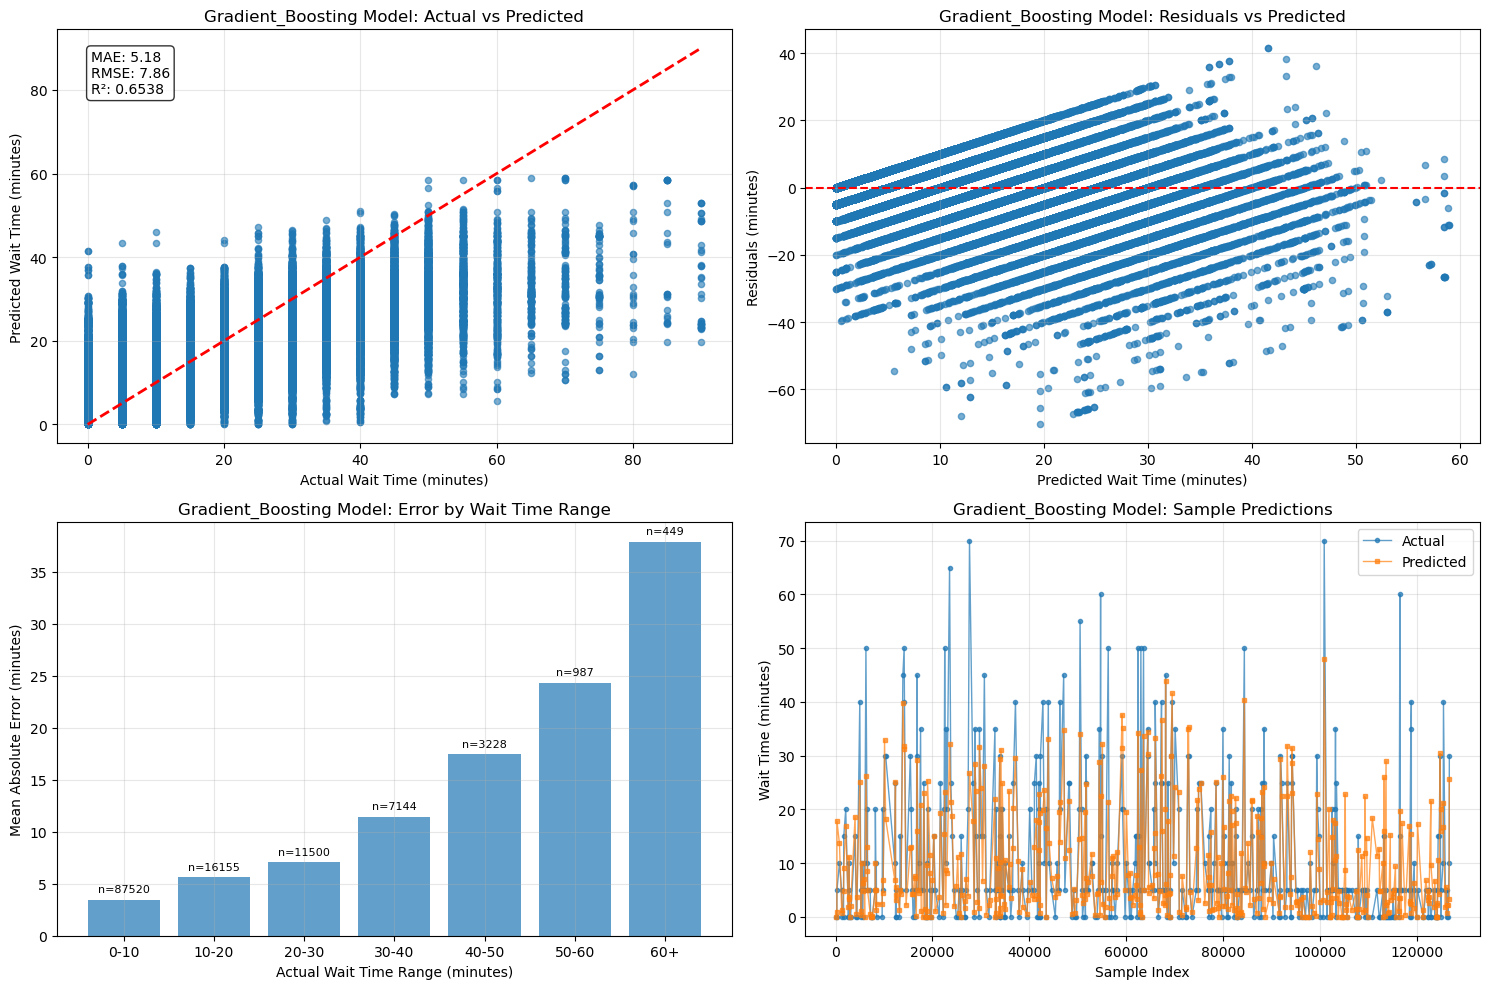


8. Creating per-ride performance visualizations...


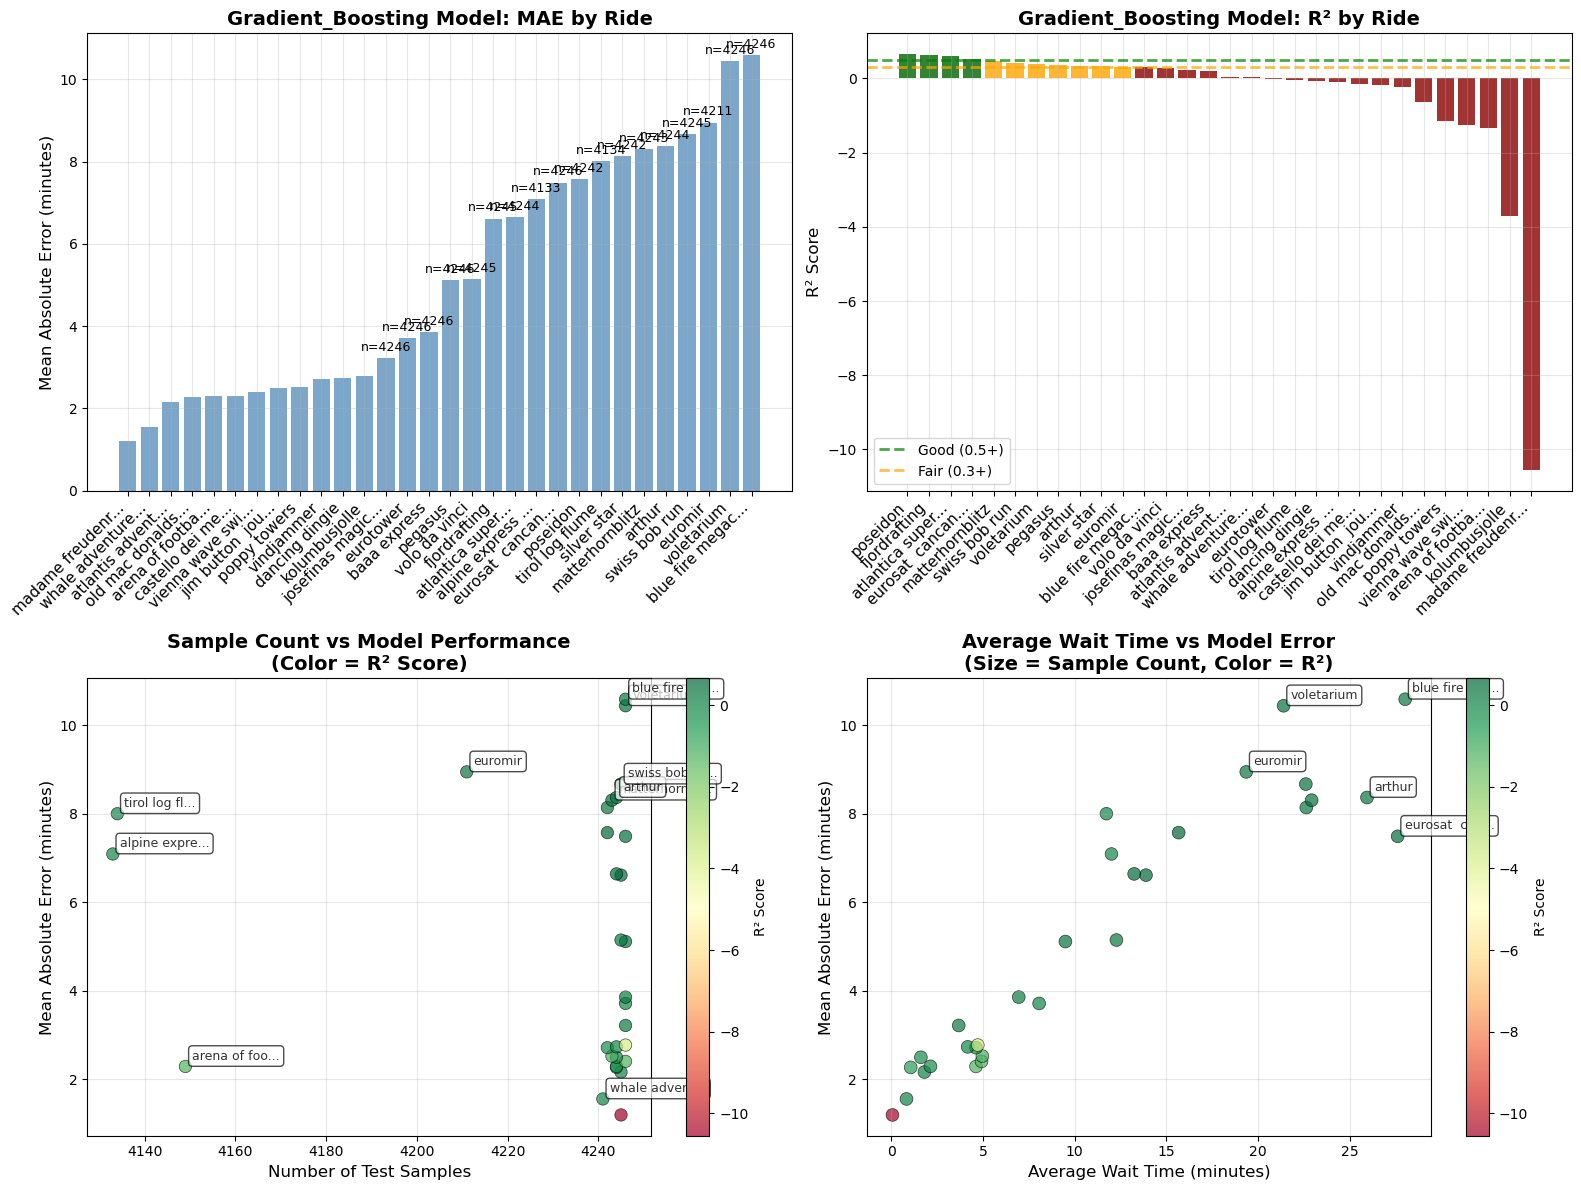

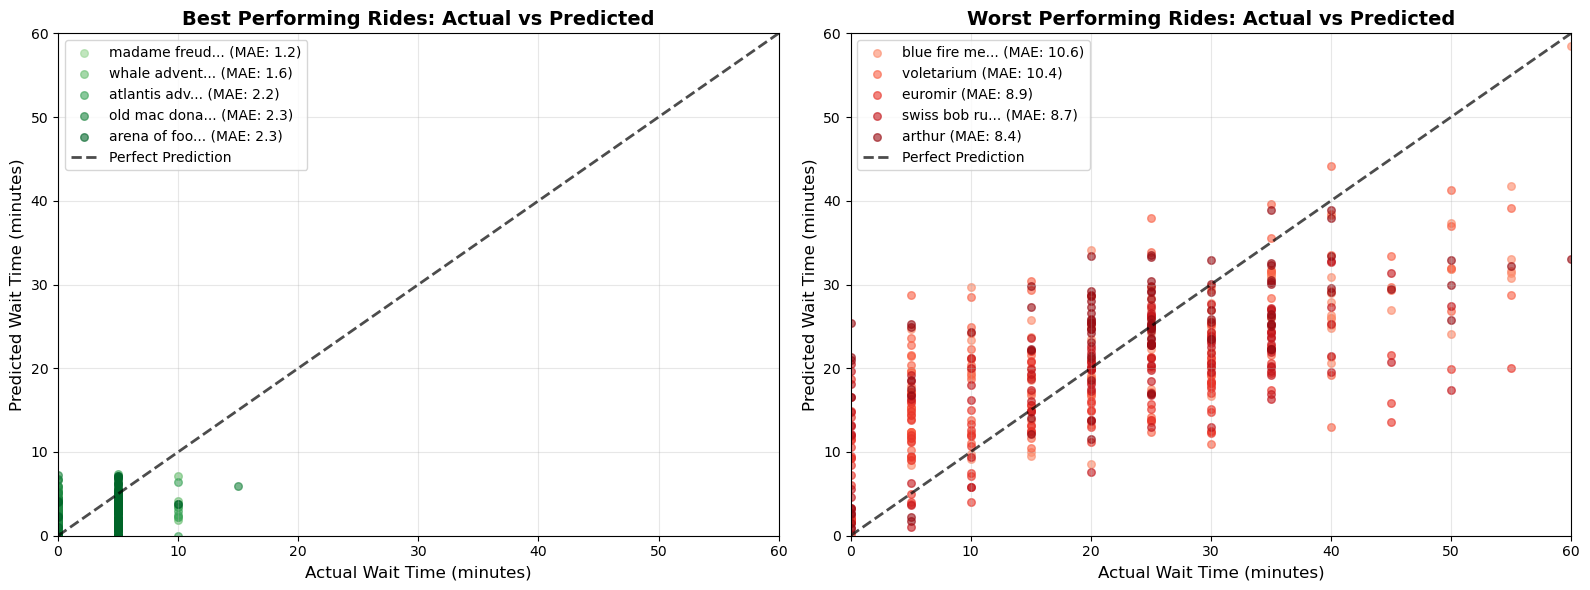

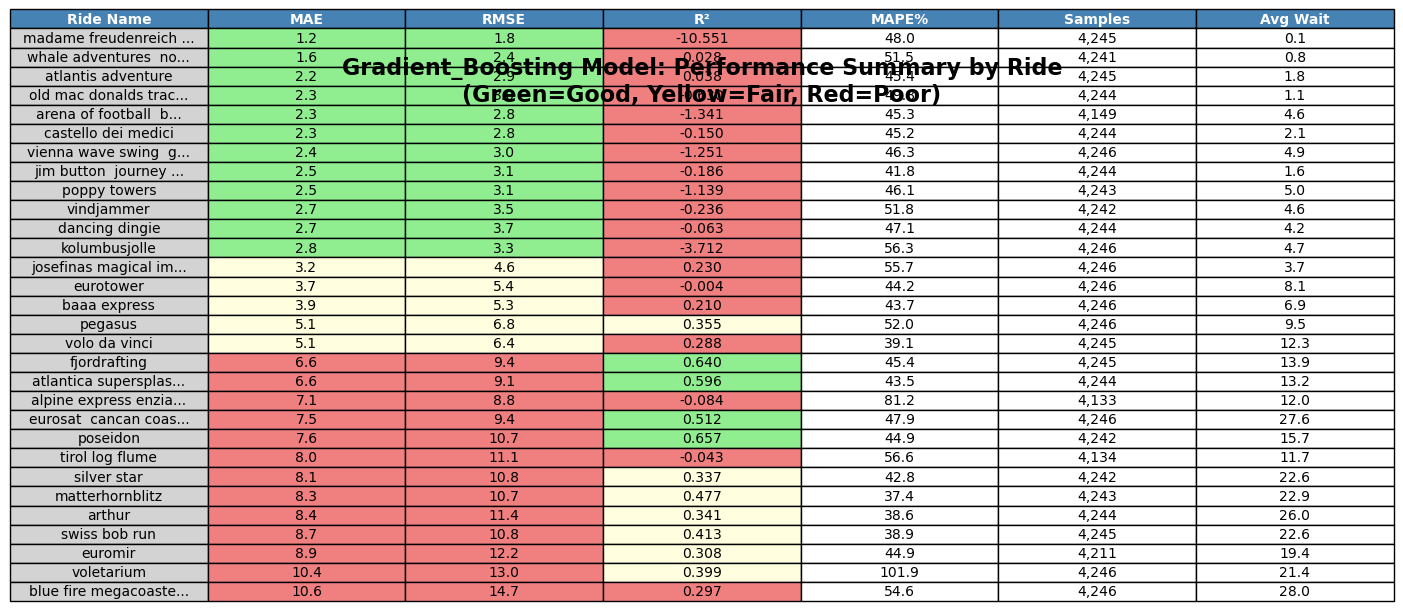


=== Per-Ride Performance Insights ===
📊 Total rides analyzed: 30
🏆 Best performing ride: madame freudenreich curiosits (MAE: 1.20 min)
⚠️  Worst performing ride: blue fire megacoaster (MAE: 10.59 min)
📈 Average MAE across all rides: 5.18 min
✅ Rides with good performance (MAE < 5 min): 15
❌ Rides with poor performance (MAE > 10 min): 2
📊 Rides with strong predictability (R² > 0.5): 4

9. Analyzing feature importance...


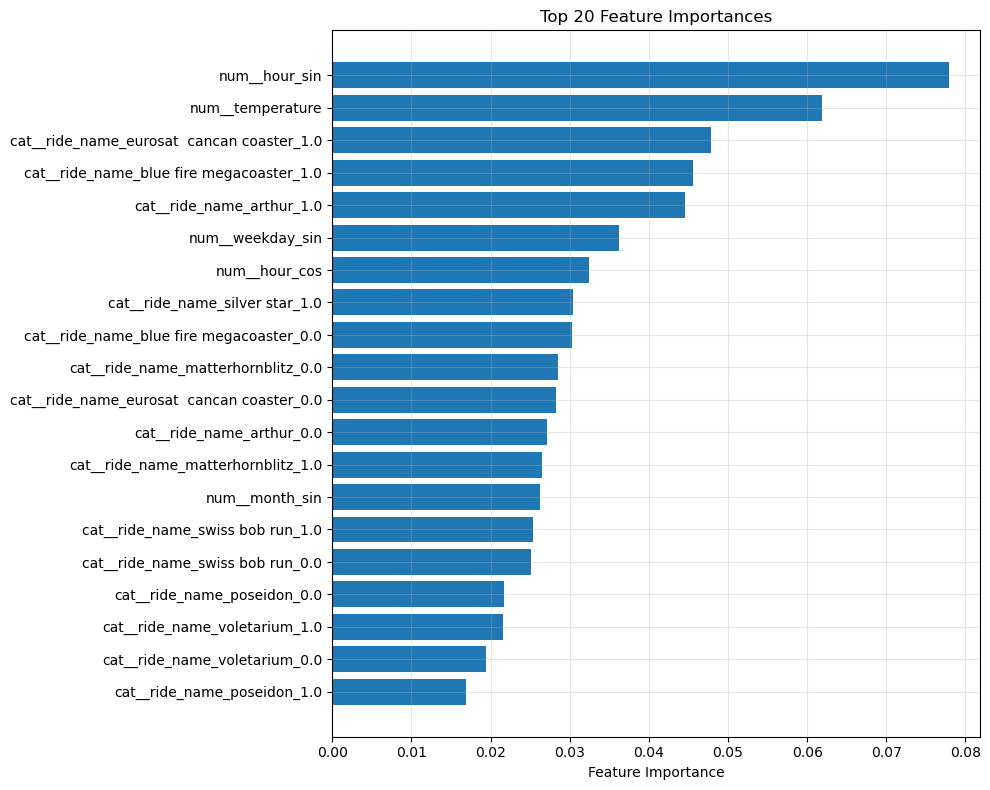

Top 10 Most Important Features:
  num__hour_sin: 0.0779
  num__temperature: 0.0619
  cat__ride_name_eurosat  cancan coaster_1.0: 0.0478
  cat__ride_name_blue fire megacoaster_1.0: 0.0456
  cat__ride_name_arthur_1.0: 0.0445
  num__weekday_sin: 0.0363
  num__hour_cos: 0.0325
  cat__ride_name_silver star_1.0: 0.0305
  cat__ride_name_blue fire megacoaster_0.0: 0.0303
  cat__ride_name_matterhornblitz_0.0: 0.0285

=== Model training completed successfully! ===
Overall model performance: MAE=5.18, RMSE=7.86, R²=0.6538
Best performing ride: madame freudenreich curiosits (MAE: 1.20)
Worst performing ride: blue fire megacoaster (MAE: 10.59)


In [13]:
model_results = main()